In [1]:
import os
os.environ['OMP_NUM_THREADS']="1"

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
from firedrake.pyplot import triplot, plot, quiver
from firedrake.cython import dmcommon
from firedrake.utils import IntType
import ufl
import finat
import tracemalloc
import gc
import pyvista as pv

In [3]:
L = 2.50
H = 0.41
Cx = 0.20  # center of hole: x
Cy = 0.20  #                 y
r = 0.05
s = r / np.sqrt(2)
x0 = 0.0
x1 = Cx - 2 * s
x2 = Cx - 1 * s
x3 = Cx + 1 * s
x4 = Cx + 2 * s
x5 = 0.6
x6 = L
y0 = 0.0
y1 = Cy - 2 * s
y2 = Cy - 1 * s
y3 = Cy + 1 * s
y4 = Cy + 2 * s
y5 = H
pointA = (0.6, 0.2)
pointB = (0.2, 0.2)
label_fluid = 1
label_struct = 2
label_left = 1
label_right = 2
label_bottom = 3
label_top = 4
label_cylinder = 5
label_interface = 6
label_cylinder_left = 11
label_cylinder_right = 12
label_cylinder_bottom = 13
label_cylinder_top = 14
label_interface_x = 15
label_interface_y = 16
label_struct_base = 20

In [4]:
h = 0.11
name = "mesh_fluid_struct"
nref = 3
#                   labels
#                      3
#    +--------------------------------------+
#    |     __ 5                             |
#    |  6 /   \ ____11_____                 |
#  4 |   |  12,13__________|10              | 2
#    |  7 \__ /      9                      |
#    |        8                             |
#    +--------------------------------------+
#                      1
import netgen
from netgen.geom2d import CSG2d, Rectangle, Circle
geo = CSG2d()
rect0 = Rectangle(pmin=(0, 0), pmax=(L, H))
circ0 = Rectangle(pmin=(x2, y2), pmax=(x3, y3))
circ1 = Rectangle(pmin=(x1, y1), pmax=(x4, y4))
rect1 = Rectangle(pmin=(Cx, 0.19), pmax=(x5, 0.21))
fluid_struct = rect0 - circ0
fluid = fluid_struct - rect1
struct = fluid_struct * rect1
geo.Add(fluid * circ1)
geo.Add(fluid - fluid * circ1)
geo.Add(struct * circ1)
geo.Add(struct - struct * circ1)
ngmesh = geo.GenerateMesh(maxh=h)
mesh = Mesh(ngmesh)
### This generates refinements of the original (very coarse) mesh
mesh = MeshHierarchy(mesh, nref, netgen_flags={"degree": 1})[-1]

/opt/firedrake/ksagiyam_submesh_core/venv/lib64/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/firedrake/ksagiyam_submesh_core/venv/lib64/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


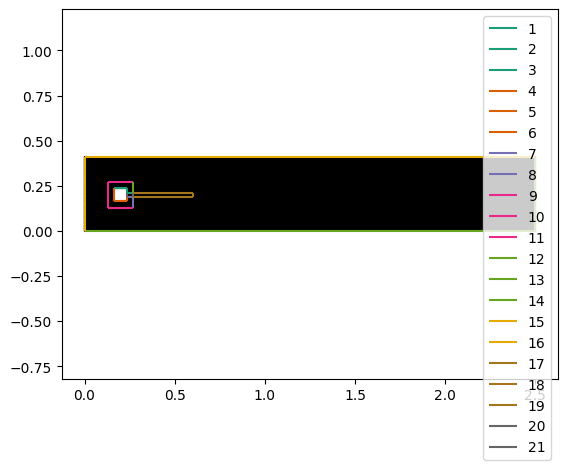

In [5]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh, axes=axes)
axes.legend()

In [6]:
mesh.topology_dm.getStratumSize('Cell Sets',1)

3887

In [7]:
x, y = SpatialCoordinate(mesh)
V = FunctionSpace(mesh, "DP", 0)
c0 = Function(V)  # to empty
c1 = Function(V).interpolate(conditional(Or(x < x3, x > x5), 1.,
                             conditional(Or(y < 0.19, y > 0.21), 1., 0.)))
c2 = Function(V).interpolate(conditional(Or(x < x3, x > x5), 0.,
                             conditional(Or(y < 0.19, y > 0.21), 0., 1.)))
print("Progress?")
V = FunctionSpace(mesh, "HDiv Trace", 0)
f0 = Function(V)  # to empty labels 8, 9, 10, 11, 12, 21
f1 = Function(V)
DirichletBC(V, 1., (16, )).apply(f1)
print("Progress?")
f2 = Function(V)
DirichletBC(V, 1., (14, )).apply(f2)
print("Progress?")
f3 = Function(V)
DirichletBC(V, 1., (13, )).apply(f3)
print("Progress?")
f4 = Function(V)
DirichletBC(V, 1., (15, )).apply(f4)
print("Progress?")
f5 = Function(V)
DirichletBC(V, 1., (2, 3, 4, 5, 6, 20)).apply(f5)
print("Progress?")
f6 = Function(V)
DirichletBC(V, 1., (1, 7, 17, 18, 19)).apply(f6)
print("Progress?")
f11 = Function(V)
DirichletBC(V, 1., (4, )).apply(f11)
print("Progress?")
f12 = Function(V)
DirichletBC(V, 1., (2, 6, 20)).apply(f12)
print("Progress?")
f13 = Function(V)
DirichletBC(V, 1., (5, )).apply(f13)
print("Progress?")
f14 = Function(V)
DirichletBC(V, 1., (3, )).apply(f14)
print("Progress?")
f15 = Function(V)
DirichletBC(V, 1., (1, 7, 17, 19)).apply(f15)
print("Progress?")
f16 = Function(V)
DirichletBC(V, 1., (18, )).apply(f16)
print("Progress?")
f20 = Function(V)
DirichletBC(V, 1., (20, )).apply(f20)
print("Progress last?")
mesh2 =  RelabeledMesh(mesh, [c0 for i in range(1, 5)] + ### Zero existing regions
                             [c1, c2] +                  ### New functions for new regions
                             [f0 for i in range(1, 22)] + ### Zero existing boundaries
                             [f1, f2, f3, f4, f5, f6] + [f11, f12, f13, f14, f15, f16, f20], ### New boundary functions
                             [i for i in range(1, 5)] + ### Regions to reset to zero
                             [label_fluid, label_struct] + ### Regions to redefine
                             [i for i in range(1, 22)] + ### Boundaries to reset to zero
                             [label_left, label_right, label_bottom, label_top, label_cylinder, label_interface] + [label_cylinder_left, label_cylinder_right, label_cylinder_bottom, label_cylinder_top, label_interface_x, label_interface_y, label_struct_base], ### Boundaries to redefine
                       name=name)

Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress?
Progress last?


In [8]:
def _mesh_displacement(V):
    f = Function(V)
    fx = f.dat.data_with_halos[:, 0]
    fy = f.dat.data_with_halos[:, 1]
    coordinates = Function(V).interpolate(V.mesh().coordinates)
    x = coordinates.dat.data_with_halos[:, 0]
    y = coordinates.dat.data_with_halos[:, 1]
    eps = 1.e-6
    cond = ((x > x1 - eps) & (x < x2 + eps) & (y > y2 - eps) & (y < y3 + eps))
    fx[cond] = - (x[cond] - x1) / (x2 - x1) * (np.sqrt(r ** 2 - (y[cond] - Cy) ** 2) - s)
    cond = ((x > x3 - eps) & (x < x4 + eps) & (y > y2 - eps) & (y < y3 + eps))
    fx[cond] = (x[cond] - x4) / (x3 - x4) * (np.sqrt(r ** 2 - (y[cond] - Cy) ** 2) - s)
    cond = ((x > x2 - eps) & (x < x3 + eps) & (y > y1 - eps) & (y < y2 + eps))
    fy[cond] = - (y[cond] - y1) / (y2 - y1) * (np.sqrt(r ** 2 - (x[cond] - Cx) ** 2) - s)
    cond = ((x > x2 - eps) & (x < x3 + eps) & (y > y3 - eps) & (y < y4 + eps))
    fy[cond] = (y[cond] - y4) / (y3 - y4) * (np.sqrt(r ** 2 - (x[cond] - Cx) ** 2) - s)
    return f

In [9]:
class DirichletBCArgyrisNoSlip(DirichletBC):
    def __init__(self, V):
        assert isinstance(V.finat_element, finat.Argyris)
        assert V.ufl_element().degree() == 5
        super().__init__(V, Constant((0., 0.)), None)
        plex = V.mesh().topology_dm
        sec = V.dm.getLocalSection()
        label = plex.getLabel("Face Sets")
        nodes = []
        for label_value, axis in [(label_left, 'y'),
                                  (label_right, 'y'),
                                  (label_bottom, 'x'),
                                  (label_top, 'x'),
                                  (label_cylinder_left, 'y'),
                                  (label_cylinder_right, 'y'),
                                  (label_cylinder_bottom, 'x'),
                                  (label_cylinder_top, 'x')]:
            local_dof_ids = {'x': [0, 1, 3],
                             'y': [0, 2, 5]}[axis]
            label_is_size = label.getStratumSize(label_value)
            if label_is_size > 0:
                label_is = label.getStratumIS(label_value)
                with label_is as points:
                    for p in points:
                        dof = sec.getDof(p)
                        off = sec.getOffset(p)
                        if dof == 0:  # cell
                            pass
                        elif dof == 1:  # facet
                            pass
                        elif dof == 6:  # vertex
                            nodes.extend([off + l for l in local_dof_ids])
                        else:
                            raise RuntimeError
        self.nodes = np.unique(np.array(nodes, dtype=IntType))


class DirichletBCEquationBCArgyrisNoSlip(DirichletBC):
    def __init__(self, V):
        assert isinstance(V.finat_element, finat.Argyris)
        assert V.ufl_element().degree() == 5
        super().__init__(V, Constant((0., 0.)), None)
        plex = V.mesh().topology_dm
        sec = V.dm.getLocalSection()
        label = plex.getLabel("Face Sets")
        nodes = []
        label_is_size = label.getStratumSize(label_struct_base)
        if label_is_size > 0:
            assert label_is_size in [1, 2], "There are only two vertices at intersection of cylinder and structure"
            label_is = label.getStratumIS(label_struct_base)
            with label_is as points:
                for p in points:
                    dof = sec.getDof(p)
                    off = sec.getOffset(p)
                    if dof == 0:  # cell
                        raise RuntimeError
                    elif dof == 1:  # facet
                        raise RuntimeError
                    elif dof == 6:  # vertex
                        nodes.extend([off + 0])
                    else:
                        raise RuntimeError
        self.nodes = np.unique(np.array(nodes, dtype=IntType))


class EquationBCArgyrisNoSlip(EquationBC):
    def __init__(self, equation, solution, V):
        assert isinstance(V.finat_element, finat.Argyris)
        assert V.ufl_element().degree() == 5
        bbc = DirichletBCEquationBCArgyrisNoSlip(V)
        super().__init__(equation, solution, None, bcs=[bbc], V=V)
        plex = V.mesh().topology_dm
        sec = V.dm.getLocalSection()
        label = plex.getLabel("Face Sets")
        nodes = []
        for label_value, axis in [(label_interface_x, 'x'),
                                  (label_interface_y, 'y')]:
            local_dof_ids = {'x': [0, 1, 3],
                             'y': [0, 2, 5]}[axis]
            label_is_size = label.getStratumSize(label_value)
            if label_is_size > 0:
                label_is = label.getStratumIS(label_value)
                with label_is as points:
                    for p in points:
                        dof = sec.getDof(p)
                        off = sec.getOffset(p)
                        if dof == 0:  # cell
                            pass
                        elif dof == 1:  # facet
                            pass
                        elif dof == 6:  # vertex
                            nodes.extend([off + l for l in local_dof_ids])
                        else:
                            raise RuntimeError(f"{dof}")
        nodes = np.unique(np.array(nodes, dtype=IntType))
        self._F.nodes = nodes
        self._J.nodes = nodes
        self._Jp.nodes = nodes

In [10]:
dim = 2
degree = 5
nref = 3
nquad = 16

/opt/firedrake/ksagiyam_submesh_core/venv/lib64/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/firedrake/ksagiyam_submesh_core/venv/lib64/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


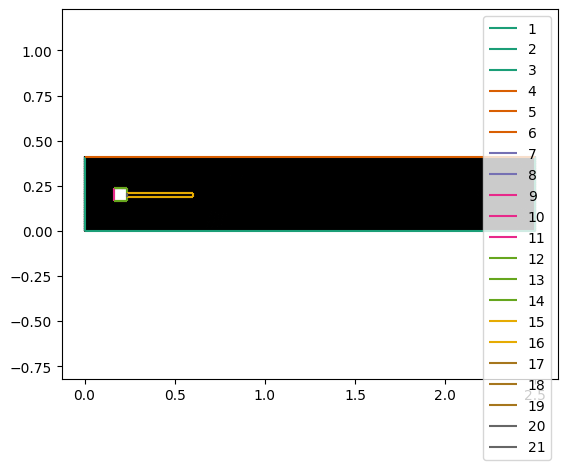

In [11]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh2, axes=axes)
axes.legend()

In [12]:
mesh_f = Submesh(mesh2, dim, label_fluid, name="mesh_fluid")
mesh_s = Submesh(mesh2, dim, label_struct, name="mesh_struct")

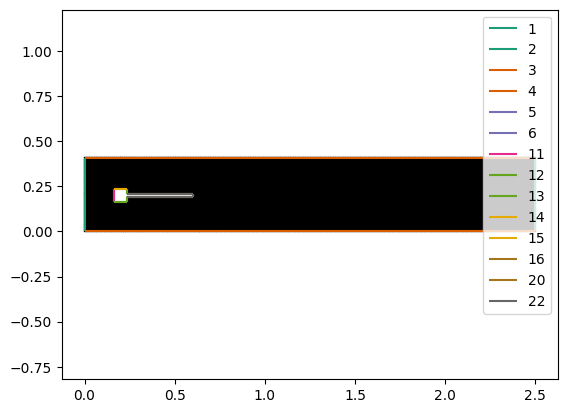

In [13]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh_f, axes=axes)
axes.legend()

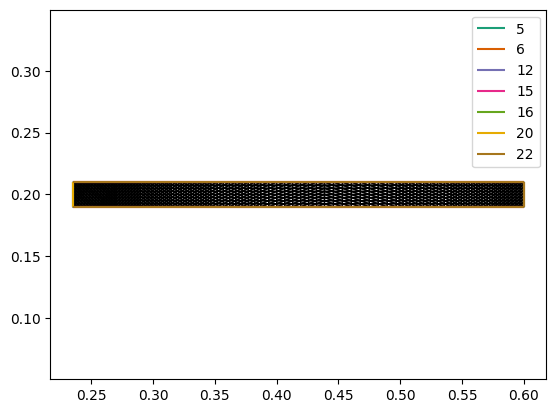

In [14]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh_s, axes=axes)
axes.legend()

In [15]:
VTKFile("mesh_ho.pvd").write(mesh)
VTKFile("mesh_ho_f.pvd").write(mesh_f)
VTKFile("mesh_ho_s.pvd").write(mesh_s)

In [16]:
x, y = SpatialCoordinate(mesh)
x_f, y_f = SpatialCoordinate(mesh_f)
x_s, y_s = SpatialCoordinate(mesh_s)
n_f = FacetNormal(mesh_f)
n_s = FacetNormal(mesh_s)
dx = Measure("dx", domain=mesh)
dx_f = Measure("dx", domain=mesh_f)
dx_s = Measure("dx", domain=mesh_s)
ds = Measure("ds", domain=mesh)
ds_f = Measure("ds", domain=mesh_f)
ds_s = Measure("ds", domain=mesh_s)
dS = Measure("dS", domain=mesh)
dS_f = Measure("dS", domain=mesh_f)
dS_s = Measure("dS", domain=mesh_s)

In [17]:
T = 20
dt = Constant(0.001)
chkstride = int(0.01 / float(dt))  # save every 0.01 sec
t = Constant(0.0)
CNshift = 1
mmt = "biharmonic"
fname_checkpoint = f"dumbdata/fsi3_P{degree}_P{degree - 2}_Argyris5_nref{nref}_{float(dt):.3f}_shift{CNshift}_{mmt}_temp"
fname_FD = f"dumbdata/time_series_FD_P{degree}_P{degree - 2}_Argyris5_nref{nref}_{float(dt):.3f}_shift{CNshift}_{mmt}_temp.dat"
fname_FL = f"dumbdata/time_series_FL_P{degree}_P{degree - 2}_Argyris5_nref{nref}_{float(dt):.3f}_shift{CNshift}_{mmt}_temp.dat"
fname_ux = f"dumbdata/time_series_ux_P{degree}_P{degree - 2}_Argyris5_nref{nref}_{float(dt):.3f}_shift{CNshift}_{mmt}_temp.dat"
fname_uy = f"dumbdata/time_series_uy_P{degree}_P{degree - 2}_Argyris5_nref{nref}_{float(dt):.3f}_shift{CNshift}_{mmt}_temp.dat"
rho_s = 1. * 1.e+3
nu_s = 0.4
mu_s = 2.0 * 1.e+6
rho_f = 1.e+3
nu_f = 1.e-3
Ubar = 2.0
# Re = 200.
g_s = Constant(0.0)
E_s = mu_s * 2 * (1 + nu_s)
lambda_s = nu_s * E_s / (1 + nu_s) / (1 - 2 * nu_s)
# ALE constants
nu_ale = Constant(float(nu_s))
mu_ale = Constant(float(mu_s))
E_ale = mu_ale * 2 * (1 + nu_ale)
lambda_ale = nu_ale * E_ale / (1 + nu_ale) / (1 - 2 * nu_ale)
V_0 = VectorFunctionSpace(mesh_f, "P", degree)
V_1 = VectorFunctionSpace(mesh_s, "Argyris", degree)
V_2 = VectorFunctionSpace(mesh_f, "Argyris", degree)
V_3 = VectorFunctionSpace(mesh_s, "Argyris", degree)
V_4 = FunctionSpace(mesh_f, "P", degree - 2)
V = V_0 * V_1 * V_2 * V_3 * V_4
solution = Function(V)
solution_0 = Function(V)
v_f, v_s, u_f, u_s, p = split(solution)
v_f_0, v_s_0, u_f_0, u_s_0, p_0 = split(solution_0)
dv_f, dv_s, du_f, du_s, dp = split(TestFunction(V))

In [18]:
for subf, name in zip(solution.subfunctions, ["v_f", "v_s", "u_f", "u_s", "p"]):
    subf.rename(name)
#
V_f_m = VectorFunctionSpace(mesh_f, "P", degree)
u_f_m = _mesh_displacement(V_f_m)
V_s_m = VectorFunctionSpace(mesh_s, "P", degree)
u_s_m = _mesh_displacement(V_s_m)

In [19]:
def compute_elast_tensors(dim, u, lambda_s, mu_s, u_m):
    F_m = Identity(dim) + grad(u_m)
    J_m = det(F_m)
    F = Identity(dim) + dot(grad(u), inv(F_m))
    J = det(F)
    E = 1. / 2. * (dot(transpose(F), F) - Identity(dim))
    S = lambda_s * tr(E) * Identity(dim) + 2.0 * mu_s * E
    return F, J, E, S, F_m, J_m
theta_p = Constant(1. / 2. + CNshift * float(dt))
theta_m = Constant(1. / 2. - CNshift * float(dt))
v_f_dot = (v_f - v_f_0) / dt
u_f_dot = (u_f - u_f_0) / dt
v_s_dot = (v_s - v_s_0) / dt
u_s_dot = (u_s - u_s_0) / dt

In [20]:
def _fluid(v_f, u_f, p, u_f_m):
    F_f, J_f, E_f, S_f, F_f_m, J_f_m = compute_elast_tensors(dim, u_f, lambda_ale, mu_ale, u_f_m)
    if mmt == "laplacian":
        mmt_domain_eq = J_f_m * inner(dot(grad(u_f), inv(F_f_m)), dot(grad(du_f), inv(F_f_m)))
    elif mmt == "elast":
        epsilon = sym(dot(grad(u_f), inv(F_f_m)))
        sigma = 2 * mu_ale * epsilon + lambda_ale * tr(epsilon) * Identity(dim)
        mmt_domain_eq = J_f_m * inner(sigma, dot(grad(du_f), inv(F_f_m)))
    elif mmt == "biharmonic":
        def grad_(u_):
            return dot(grad(u_), inv(F_f_m))
        def tr3(tensor_):
            ii, jj, kk = ufl.indices(3)
            part = ufl.classes.ComponentTensor(tensor_[ii, jj, kk], ufl.classes.MultiIndex((jj, kk)))
            return ufl.classes.ComponentTensor(tr(part), ufl.classes.MultiIndex((ii, )))
        mmt_domain_eq = J_f_m * inner(tr3(grad_(grad_(u_f))), tr3(grad_(grad_(du_f))))
    else:
        raise NotImplementedError(f"Unknown mmt : {mmt}")
    return (inner(rho_f * J_f * J_f_m * v_f_dot, dv_f) +
            inner(rho_f * J_f * J_f_m * dot(dot(dot(grad(v_f), inv(F_f_m)), inv(F_f)), v_f - u_f_dot), dv_f) +
            inner(rho_f * J_f * J_f_m * nu_f * 2 * sym(dot(dot(grad(v_f), inv(F_f_m)), inv(F_f))), dot(dot(grad(dv_f), inv(F_f_m)), inv(F_f))) -
            J_f * J_f_m * inner(p, tr(dot(dot(grad(dv_f), inv(F_f_m)), inv(F_f)))) +
            J_f * J_f_m * inner(tr(dot(dot(grad(v_f), inv(F_f_m)), inv(F_f))), dp) +
            mmt_domain_eq) * dx_f(degree=nquad)
def _struct(v_f, u_f, p, v_s, u_s, u_f_m, u_s_m):
    F_f, J_f, E_f, S_f, F_f_m, J_f_m = compute_elast_tensors(dim, u_f, lambda_s, mu_s, u_f_m)
    F_s, J_s, E_s, S_s, F_s_m, J_s_m = compute_elast_tensors(dim, u_s, lambda_s, mu_s, u_s_m)
    return (inner(rho_s * J_s * J_s_m * v_s_dot, dv_s) +
            inner(J_s_m * dot(F_s, S_s), dot(grad(dv_s), inv(F_s_m))) -
            inner(rho_s * J_s * J_s_m * as_vector([0., - g_s]), dv_s) +
            inner(J_s * J_s_m * (u_s_dot - v_s), du_s)) * dx_s(degree=nquad) + \
           inner(dot(- p * Identity(dim) + rho_f * nu_f * 2 * sym(dot(dot(grad(v_f), inv(F_f_m)), inv(F_f))), dot(dot(J_f * transpose(inv(F_f)), J_f_m * transpose(inv(F_f_m))), n_f)), dv_s) * ds_s(label_interface, degree=nquad)
residual_f = theta_p * _fluid(v_f, u_f, p, u_f_m) + \
             theta_m * _fluid(v_f_0, u_f_0, p_0, u_f_m)
residual_s = theta_p * _struct(v_f, u_f, p, v_s, u_s, u_f_m, u_s_m) + \
             theta_m * _struct(v_f_0, u_f_0, p_0, v_s_0, u_s_0, u_f_m, u_s_m)
residual = residual_f + residual_s

In [21]:
def v_f_left(t_):
    return 1.5 * Ubar * y_f * (H - y_f) / ((H / 2) ** 2) * conditional(t_ < 2.0 + dt / 10., (1 - cos(pi / 2 * t_)) / 2., 1.)

In [22]:
bc_v_f_inflow = DirichletBC(V.sub(0), as_vector([theta_p * v_f_left(t - dt + theta_p * dt) +
                                                 theta_m * v_f_left(t - dt + theta_m * dt), 0.]), (label_left, ))
bc_v_f_zero = DirichletBC(V.sub(0), Constant((0, 0)), (label_bottom, label_top, label_cylinder))
bbc_v_f_noslip = DirichletBC(V.sub(0), Constant((0, 0)), ((label_cylinder, label_interface), ))
bc_v_f_noslip = EquationBC(inner(v_f - v_s, dv_f) * ds_f(label_interface) == 0, solution, label_interface, bcs=[bbc_v_f_noslip], V=V.sub(0))
bc_v_s_zero = DirichletBCArgyrisNoSlip(V.sub(1))
bc_u_f_zero = DirichletBCArgyrisNoSlip(V.sub(2))
bc_u_f_noslip = EquationBCArgyrisNoSlip(inner(u_f - u_s, du_f) * ds_f(label_interface) == 0, solution, V.sub(2))
bc_u_s_zero = DirichletBCArgyrisNoSlip(V.sub(3))

In [23]:
solver_parameters = {
    "mat_type": "aij",
    "snes_mat_it": 1000,
    "snes_rtol": 1.e-10,
    "snes_atol": 1.e-10,
    "snes_monitor": None,
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
solver_parameters_fieldsplit = {
    #'mat_type': 'matfree',
    'ksp_type': 'gmres',
    'pc_type': 'fieldsplit',
    'pc_fieldsplit_type': 'schur',
    'fieldsplit_schur_fact_type': 'full',
    "pc_fieldsplit_0_fields": "0, 2",
    "pc_fieldsplit_1_fields": "1",
    'fieldsplit_0': {
        'ksp_type': 'preonly',
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps"
        #'ksp_type': 'gmres',  # equationBC is nonsym
        #'pc_type': 'python',
        #'pc_python_type': 'firedrake.AssembledPC',
        #'assembled_pc_type': 'gamg',
        #'assembled_mg_levels_pc_type': 'sor',
        #'assembled_mg_levels_pc_sor_diagonal_shift': 1e-100,
        #'ksp_rtol': 1e-7,
        #'ksp_converged_reason': None,
    },
    'fieldsplit_1': {
        'ksp_type': 'preonly',
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps"
        #'ksp_type': 'fgmres',
        #'ksp_converged_reason': None,
        #'pc_type': 'python',
        #'pc_python_type': 'firedrake.MassInvPC',
        #'Mp_pc_type': 'ksp',
        #'Mp_ksp_ksp_type': 'cg',
        #'Mp_ksp_pc_type': 'sor',
        #'ksp_rtol': '1e-5',
        #'ksp_monitor': None,
    },
    "snes_monitor": None,
    'ksp_monitor': None,
    'ksp_view': None,
}

In [24]:
problem = NonlinearVariationalProblem(residual, solution, bcs=[bc_v_f_inflow, bc_v_f_zero, bc_v_f_noslip, bc_u_f_zero, bc_u_f_noslip, bc_v_s_zero, bc_u_s_zero])
solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters)

In [25]:
print("num cells = ", mesh.comm.allreduce(mesh.cell_set.size), flush=True)
print("num DoFs = ", V.dim(), flush=True)

num cells =  20032
num DoFs =  754260


In [26]:
print(f"nu_ale = {float(nu_ale)}")
print(f"mu_ale = {float(mu_ale)}")
print(f"labmda_ale = {float(lambda_ale)}")

nu_ale = 0.4
mu_ale = 2000000.0
labmda_ale = 8000000.000000002


In [27]:
F_f_, J_f_, _, _, F_f_m_, J_f_m_ = compute_elast_tensors(dim, u_f, lambda_s, mu_s, u_f_m)

In [28]:
sigma_f_ = - p * Identity(dim) + rho_f * nu_f * 2 * sym(dot(dot(grad(v_f), inv(F_f_m_)), inv(F_f_)))

In [29]:
iplot = 0
if mesh.comm.rank == 0:
    with open(fname_FD, 'w') as outfile:
         outfile.write("t val" + "\n")
    with open(fname_FL, 'w') as outfile:
         outfile.write("t val" + "\n")
    with open(fname_ux, 'w') as outfile:
         outfile.write("t val" + "\n")
    with open(fname_uy, 'w') as outfile:
         outfile.write("t val" + "\n")

In [30]:
ii = 0
u_3 = Function(VectorFunctionSpace(mesh_s, "P", degree))

In [ ]:
while float(t) < T:
    t.assign(float(t) + float(dt))
    ii += 1
    if mesh.comm.rank == 0:
        print(f"Computing solution at time = {float(t)} (dt = {float(dt)}, CNshift={CNshift})", flush=True)
    solver.solve()
    for subfunction, subfunction_0 in zip(solution.subfunctions, solution_0.subfunctions):
        subfunction_0.assign(subfunction)
    # Everything is now up to date.
    FD = assemble(-dot(sigma_f_, dot(dot(J_f_ * transpose(inv(F_f_)), J_f_m_ * transpose(inv(F_f_m_))), n_f))[0] * ds_f(subdomain_id=(label_cylinder, label_interface), degree=nquad))
    FL = assemble(-dot(sigma_f_, dot(dot(J_f_ * transpose(inv(F_f_)), J_f_m_ * transpose(inv(F_f_m_))), n_f))[1] * ds_f(subdomain_id=(label_cylinder, label_interface), degree=nquad))
    u_A = u_3.project(solution.subfunctions[3], solver_parameters={"ksp_rtol": 1.e-10}).at(pointA, tolerance=1.e-6)
    if mesh.comm.rank == 0:
        print(f"FD     = {FD}")
        print(f"FL     = {FL}")
        print(f"uA     = {u_A}")
        if ii % chkstride == 0:c
            with open(fname_FD, 'a') as outfile:
                outfile.write(f"{float(t)} {FD}" + "\n")
            with open(fname_FL, 'a') as outfile:
                outfile.write(f"{float(t)} {FL}" + "\n")
            with open(fname_ux, 'a') as outfile:
                outfile.write(f"{float(t)} {u_A[0]}" + "\n")
            with open(fname_uy, 'a') as outfile:
                outfile.write(f"{float(t)} {u_A[1]}" + "\n")
    if ii % chkstride == 0:
        iplot += 1
        with DumbCheckpoint(fname_checkpoint, mode=FILE_UPDATE) as chk:
            chk.set_timestep(float(t), iplot)
            for subsolution in solution.subfunctions:
                chk.store(subsolution)
    gc.collect()

In [33]:
solution.subfunctions

(Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f7d1f2042f0>, VectorElement(FiniteElement('Lagrange', triangle, 5), dim=2), name=None, index=0, component=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 29)), 88),
 Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f7d1f59e090>, VectorElement(FiniteElement('Argyris', triangle, 5), dim=2), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 31)), 89),
 Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f7d1f2042f0>, VectorElement(FiniteElement('Argyris', triangle, 5), dim=2), name=None, index=2, component=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 29)), 90),
 Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f7d1f59e090>, VectorElement(FiniteElement('Argyris', 

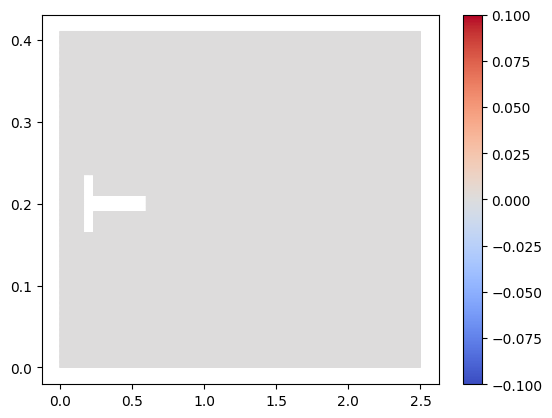

In [41]:
fig, axes = plt.subplots()
collection = tripcolor(solution.sub(4), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

In [43]:
label_interface

6

/opt/firedrake/ksagiyam_submesh_core/venv/lib64/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/firedrake/ksagiyam_submesh_core/venv/lib64/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


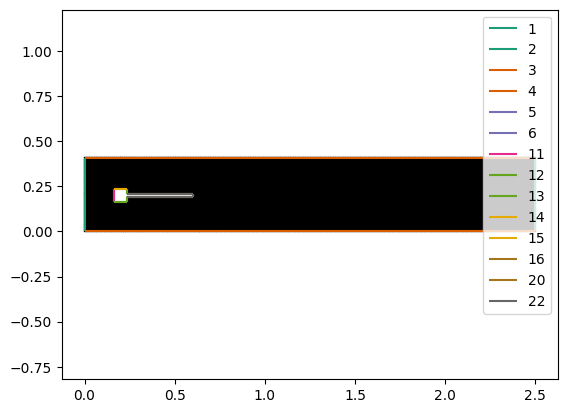

In [45]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh_f, axes=axes)
axes.legend()